In [2]:
import numpy as np
import numba
import pandas as pd
import collections
import scipy.optimize
import statsmodels.tools.numdiff as smnd
import bebi103
# Import pyplot for plotting
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import corner
from scipy.integrate import trapz, simps

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

Problem 5.1:

In [3]:
df = pd.read_csv('../data/fret_binding_curve.csv', comment='#')

In [4]:
df.head()

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.00
1,1256.5751,267722.6277,50.0,750.00
2,1256.5751,267431.6620,50.0,375.00
3,1256.5751,284596.2914,50.0,187.50
4,1256.5751,254903.3958,50.0,93.75


The data look tidy. To find the background-adjusted fluorescence, we simply subtract the buffer:

In [5]:
df['back_subt_fluor'] = df['fluorescence'] - df['buffer']

In [6]:
df

,buffer,fluorescence,a conc (nM),b conc (nM),back_subt_fluor
0,1256.5751,258316.2818,50.0,1500.000000,257059.7067
1,1256.5751,267722.6277,50.0,750.000000,266466.0526
2,1256.5751,267431.6620,50.0,375.000000,266175.0869
3,1256.5751,284596.2914,50.0,187.500000,283339.7163
4,1256.5751,254903.3958,50.0,93.750000,253646.8207
5,1256.5751,333810.6371,50.0,46.875000,332554.0620
6,1256.5751,370821.7778,50.0,23.437500,369565.2027
7,1256.5751,408856.1424,50.0,11.718750,407599.5673
8,1256.5751,431000.0000,50.0,5.859375,429743.4249
9,1256.5751,437000.0000,50.0,0.000000,435743.4249


The FRET efficiency is given by the following expression: 

\begin{align}
e = 1 - \frac{F}{F_0}
\end{align}

Since $F_0$ is defined as the fluorescence when the concentration of protein b is zero, we can simply take the fluorescence level of the last row. 

\begin{align}
e = 1 - \frac{F}{F_0} = 1 - \frac{F}{435743.4249}
\end{align}

In [7]:
fret_e = []
for i in range(10):
    if i != 9:
        fret_e.append(1 - df['fluorescence'][i] / df['back_subt_fluor'][9])
    else:
        fret_e.append(0)

In [8]:
df['FRET efficiency'] = fret_e

We now have the FRET efficiency for each measurement as a separate column: 

In [9]:
df

,buffer,fluorescence,a conc (nM),b conc (nM),back_subt_fluor,FRET efficiency
0,1256.5751,258316.2818,50.0,1500.000000,257059.7067,0.407183
1,1256.5751,267722.6277,50.0,750.000000,266466.0526,0.385596
2,1256.5751,267431.6620,50.0,375.000000,266175.0869,0.386263
3,1256.5751,284596.2914,50.0,187.500000,283339.7163,0.346872
4,1256.5751,254903.3958,50.0,93.750000,253646.8207,0.415015
5,1256.5751,333810.6371,50.0,46.875000,332554.0620,0.233928
6,1256.5751,370821.7778,50.0,23.437500,369565.2027,0.148991
7,1256.5751,408856.1424,50.0,11.718750,407599.5673,0.061704
8,1256.5751,431000.0000,50.0,5.859375,429743.4249,0.010886
9,1256.5751,437000.0000,50.0,0.000000,435743.4249,0.000000


For 5.1, we will use parameter estimation by optimization. 

In [10]:
def fret_eff(p, ca, cb):
    alpha, kd = p
    return 2 * alpha * cb / (kd + ca + cb + np.sqrt((kd + ca + cb)**2 - 4 * ca * cb))

In [11]:
def log_post(p, ca, cb, e_measure):
    alpha, kd = p
    e_theor = fret_eff(p, ca, cb)
    return -len(ca) / 2 * np.log(np.sum((e_measure - e_theor)**2))

In [12]:
def resid(p, ca, cb, e_measure):
    """
    Residuals for spindle length model.
    """
    return e_measure - fret_eff(p, ca, cb)

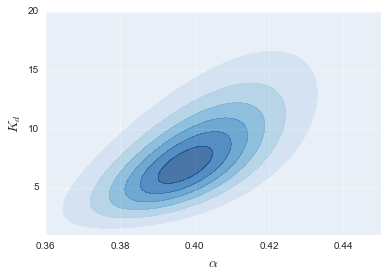

In [13]:
alpha = np.linspace(0.36, 0.45, 100)
kd = np.linspace(1, 20, 100)

# Make a grid
tt, gg = np.meshgrid(alpha, kd)

# Compute log posterior
log_posterior = np.empty_like(tt)
for j in range(len(alpha)):
    for i in range(len(kd)):
        log_posterior[i, j] = log_post(np.array([tt[i,j], gg[i,j]]), df['a conc (nM)'], df['b conc (nM)'], df['FRET efficiency'])

# Get things to scale better
log_posterior -= log_posterior.max()
        
# Plot the results
plt.contourf(tt, gg, np.exp(log_posterior), cmap=plt.cm.Blues, alpha=0.7)
plt.xlabel(r'$\alpha$' )
plt.ylabel(r'$K_d$');

The plot suggests that the most probable values for $\alpha$ and $K_d$ are approximately 0.395 and 7, respectively.

We can now use the least squares estimation method to find the most probable parameters.

In [14]:
p0 = np.array([0.395, 7.5])

In [15]:
args = ( df['a conc (nM)'].values, df['b conc (nM)'].values, df['FRET efficiency'].values)

In [16]:
popt, _ = scipy.optimize.leastsq(resid, p0, args=args)

In [17]:
# Extract the values
alpha, kd = popt

# Print results
print("""
Most probable parameters
----------------------------------
alpha = {0:.3f} 
K_d = {1:.3f}
""".format(alpha, kd))


Most probable parameters
----------------------------------
alpha = 0.397 
K_d = 6.858



Now, let's get the error bars on the two parameters:

In [18]:
hes = smnd.approx_hess(popt, log_post, args=args)
cov = -np.linalg.inv(hes)
# Report results
print("""
Regression results without an outlier detection scheme (≈ 68% of total probability)
------------------------------------------------
alpha = {0:.3f} ± {1:.3f} 
K_d = {2:.3f} ± {3:.3f}
""".format(alpha, np.sqrt(cov[0,0]), kd, np.sqrt(cov[1,1])))


Regression results without an outlier detection scheme (≈ 68% of total probability)
------------------------------------------------
alpha = 0.397 ± 0.016 
K_d = 6.858 ± 3.425



Let's see how this looks graphically:

First, we start with alpha:

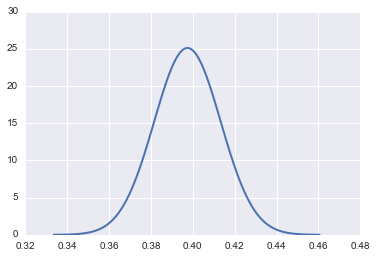

In [19]:
mu = alpha
std = np.sqrt(cov[0,0])
x = np.linspace(0.397-4*std, 0.397+4*std, 100)
plt.plot(x,mlab.normpdf(x, mu, std))
plt.show()

Next, we plot K_d:

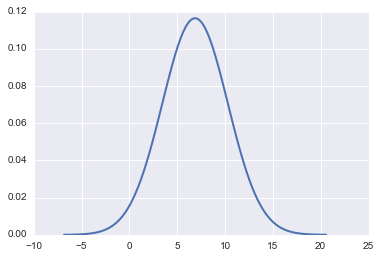

In [20]:
mu = backup_mu = kd
std = backup_std = np.sqrt(cov[1,1])
x = backup_x = np.linspace(mu-4*std, mu+4*std, 100)
plt.plot(x, mlab.normpdf(x, mu, std))
plt.show()

Notice that the problem with using a Gaussian model for bounded values becomes more apparent with the plot for K_d. We know that K_d is positive. However, due to the infinite span of the bell curve, the probability associated with a negative posterior is nonzero. In fact, it's a considerable percentage of the total area under the curve. 

Now, let's use a Cauchy fit to estimate K_d, accomodating for any outliers in the data.  

In [20]:
#@numba.jit(nopython=True)
def log_likelihood_cauchy(p, x, conc_a, conc_b):
    """
    Cauchy log likelihood.
    """
    logkd, beta, alpha = p
    #kd = np.exp(logkd)
    return -len(x) * np.log(beta) - np.sum(np.log(1.0 + ((x - e_theor(p, conc_a, conc_b)) / beta)**2))

def e_theor(p, conc_a, conc_b):
    logkd, beta, alpha = p
    kd = np.exp(logkd)
    return (2 * alpha * conc_b) / (kd + conc_a + conc_b + np.sqrt((kd + conc_a + conc_b) ** 2 - 4 * conc_a * conc_b))
    
#@numba.jit(nopython=True)
def log_prior_cauchy(p, kd_min, kd_max, alpha_min, alpha_max):
    """
    Log prior.
    """
    logkd, beta, alpha = p
    kd = np.exp(logkd)
    if (not (kd_min < kd < kd_max)) or beta <= 0 or (not (alpha_min < alpha < alpha_max)):
        return -np.inf
    else:
        return -np.log(beta) - np.log(kd_max - kd_min) - np.log(alpha_max - alpha_min)  #Change


#@numba.jit(nopython=True)
def log_posterior_cauchy(p, x, kd_min, kd_max, alpha_min, alpha_max, conc_a, conc_b):
    """
    Log posterior.  

    """
    lp = log_prior_cauchy(p, kd_min, kd_max, alpha_min, alpha_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood_cauchy(p, x, conc_a, conc_b)

In [21]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Set up parameters
p_dict = collections.OrderedDict(
        [('logkd', (np.random.uniform, (-10, 4,))),
         ('beta', (np.random.exponential, (1,))),
         ('alpha', (np.random.uniform, (0, 1,)))])


# Run MCMC
# What should I pass as args for the Cauchy generations? How do we get the measured k_d's? 
x = df['FRET efficiency']
conc_a = df['a conc (nM)']
conc_b = df['b conc (nM)']
args=(x, 10**-10, 10**4, 0, 1, conc_a, conc_b)   
df_mcmc = bebi103.run_ensemble_emcee(log_posterior_cauchy, p_dict=p_dict, args=args, n_walkers=50, n_burn=5000, n_steps=5000)

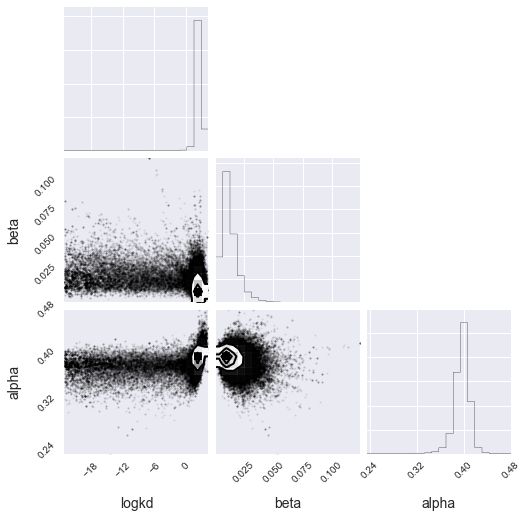

In [22]:
corner.corner(df_mcmc[['logkd', 'beta', 'alpha']], labels=['logkd', 'beta', 'alpha']  );

To find K_d with the outlier detection mechanism, we can take the most probable value (the peak) of the distribution.

In [27]:
df_mcmc.head()

,logkd,beta,alpha,lnprob,chain
0,2.173055,0.015181,0.376769,27.398846,0
1,2.173055,0.015181,0.376769,27.398846,0
2,2.173055,0.015181,0.376769,27.398846,0
3,2.301885,0.015868,0.382263,27.998105,0
4,2.301885,0.015868,0.382263,27.998105,0


In [30]:
df_mcmc['lnprob'] = df_mcmc['lnprob'].astype(np.float64)
df_mcmc['logkd'] = df_mcmc['logkd'].astype(np.float64)

In [31]:
prevmax = 0
for i in range(len(df_mcmc['lnprob'])):
    if df_mcmc['lnprob'][i] > prevmax:
        prevmax = i
df_mcmc['logkd'][prevmax]        

2.4501908275877065

In [33]:
kd_estimate = np.exp(df_mcmc['logkd'][prevmax])
kd_estimate

11.590558306482544

Using the Cauchy distribution as the outlier detection scheme, we get Kd = 11.6

Now, we will present a graphical summary of the regression results: 

In [36]:
def hpd(trace, mass_frac) :
    """
    Returns highest probability density region given by
    a set of samples.

    Parameters
    ----------
    trace : array
        1D array of MCMC samples for a single variable
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
        
    Returns
    -------
    output : array, shape (2,)
        The bounds of the HPD
    """
    # Get sorted list
    d = np.sort(np.copy(trace))

    # Number of total samples taken
    n = len(trace)
    
    # Get number of samples that should be included in HPD
    n_samples = np.floor(mass_frac * n).astype(int)
    
    # Get width (in units of data) of all intervals with n_samples samples
    int_width = d[n_samples:] - d[:n-n_samples]
    
    # Pick out minimal interval
    min_int = np.argmin(int_width)
    
    # Return interval
    return np.array([d[min_int], d[min_int+n_samples]])

In [44]:
HPD_array = np.exp(hpd(df_mcmc['logkd'], 0.95))
HPD_array

array([  4.36711167e-03,   4.59552816e+01])

The HPD range (95%) is given by 0.00437 < Kd < 46

Notice that this range is very wide! It spans over 4 orders of magnitude. 

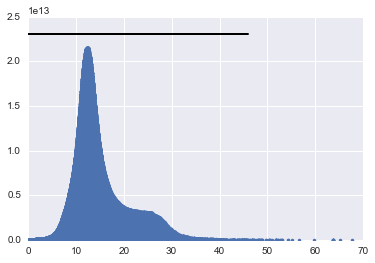

In [47]:
plt.plot(np.exp(df_mcmc['logkd']), np.exp(df_mcmc['lnprob']), '.')
plt.plot([HPD_array[0], HPD_array[1]], [2.3e13, 2.3e13], color='k', linestyle='-', linewidth=2)

Notice that the above plot is not normalized. We will normalize the probabilities so that they add up to one.

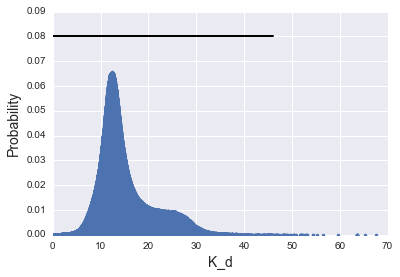

In [59]:
norm_factor = trapz((np.exp(df_mcmc['lnprob'])), np.exp(df_mcmc['logkd']))
plt.plot(np.exp(df_mcmc['logkd']), np.exp(df_mcmc['lnprob']) / norm_factor, '.')
plt.plot([HPD_array[0], HPD_array[1]], [0.08, 0.08], color='k', linestyle='-', linewidth=2)
plt.xlabel('K_d')
plt.ylabel('Probability')

The black line represents the 95% HPD. 

Let's now compare the two estimates we obtained for K_d:

Using the outlier detection scheme, we estimated K_d as 11.6. 
Without the outlier detection scheme, we estimated K_d as 6.9. 

The magnitudes of K_d differ by a lot, but for each of the two methods, the K_d corresponding to the other method is within the 95% confidence interval. In other words, outliers had enough dominance to sway our estimate of K_d by 65%, but the resulting estimate was still within our confidence interval. When we tried to detect the outliers, our estimate of the mean increased because the broad tail of the Cauchy distribution allowed for a large array of possible values that K_d could take. Those low-probability, high-impact points skewed the mean up by a noticeable amount, but not outside the 95% range.